In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from tqdm import tqdm
import os
from matplotlib import pyplot as plt 
import cv2
import numpy as np
import scipy.ndimage
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F

In [2]:
class CSRNet(nn.Module):
    def __init__(self, load_pretrained=True):
        super(CSRNet, self).__init__()

        vgg = models.vgg16(pretrained=load_pretrained)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])  # Up to conv4_3

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
        )

        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return x


In [3]:
class CrowdDataset(Dataset):
    def __init__(self, image_folder, density_map_folder, image_files, transform=None):
        self.image_folder = image_folder
        self.density_map_folder = density_map_folder
        self.image_files = image_files # Ensure sorted list
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_files[idx]
        # print(img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = image.astype(np.float32) / 255.0  # Normalize to [0,1]

        # Load density map (.npy file)
        density_map_name = self.image_files[idx].replace('.jpg', '_density.npy').replace(self.image_folder, self.density_map_folder)  # or '.png' -> '.npy'
        density_map = np.load(density_map_name)  # Loads (H, W) float32 density map

        # Convert to torch tensors
        image = torch.from_numpy(image).permute(2, 0, 1)  # (C, H, W)
        density_map = torch.from_numpy(density_map).unsqueeze(0).float()  # (1, H, W)

        if self.transform:
            image = self.transform(image)

        return image, density_map

In [4]:
train_resized_folder = "Train_resized_2"
train_density_folder = "Train_density_2"

train_image_paths = []
train_heatmap_paths = []

# Iterate over files in Train_resized folder
for file_name in os.listdir(train_resized_folder):
    if file_name.endswith(".jpg"):
        train_image_paths.append(os.path.join(train_resized_folder, file_name))

# Iterate over files in Train_density folder
for file_name in os.listdir(train_density_folder):
    if file_name.endswith(".npy"):
        train_heatmap_paths.append(os.path.join(train_density_folder, file_name))

print(f"Found {len(train_image_paths)} images and {len(train_heatmap_paths)} heatmaps.")


validation_resized_folder = "Validation_resized_2"
validation_density_folder = "Validation_density_2"
validation_image_paths = []
validation_heatmap_paths = []

# Iterate over files in Validation_resized folder
for file_name in os.listdir(validation_resized_folder):
    if file_name.endswith(".jpg"):
        validation_image_paths.append(os.path.join(validation_resized_folder, file_name))

# Iterate over files in Validation_density folder
for file_name in os.listdir(validation_density_folder):
    if file_name.endswith(".npy"):
        validation_heatmap_paths.append(os.path.join(validation_density_folder, file_name))

print(f"Found {len(validation_image_paths)} images and {len(validation_heatmap_paths)} heatmaps.")

Found 4804 images and 4804 heatmaps.
Found 668 images and 668 heatmaps.


In [5]:
train_dataset = CrowdDataset(train_resized_folder, train_density_folder, train_image_paths)
validation_dataset = CrowdDataset(validation_resized_folder, validation_density_folder, validation_image_paths)

In [6]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
def train_model(model, train_loader, val_loader=None, num_epochs=10, lr=1e-5, device='cuda'):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # TRAINING
        for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            # print(outputs.shape, targets.shape)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        print(f"\nEpoch {epoch+1} - Train Loss: {avg_train_loss:.10f}")

        # VALIDATION
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, targets in val_loader:
                    images = images.to(device)
                    targets = targets.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * images.size(0)

            avg_val_loss = val_loss / len(val_loader.dataset)
            print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.10f}")

    return model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CSRNet().to(device)
print(device)
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=10, shuffle=False)

C:\Users\ryan_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ryan_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cpu


In [ ]:
trained_model = train_model(model, train_loader, val_loader, num_epochs=3, lr=1e-6, device='cpu')

In [8]:
def visualize_output(model, dataset, device='cuda', index=0):
    model.eval()
    
    # Get a sample
    image, gt_density = dataset[index]
    image = image.to(device).unsqueeze(0)  # Add batch dim
    gt_density = gt_density.squeeze().cpu().numpy()

    # Predict
    with torch.no_grad():
        output = model(image)
        output = F.interpolate(output, size=(224, 224), mode='bilinear', align_corners=False)
        output = output.squeeze().cpu().numpy()


    # Count predictions
    predicted_count = output.sum()
    gt_count = gt_density.sum()

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Original image
    axs[0].imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    # Predicted density map
    axs[1].imshow(output, cmap='jet')
    axs[1].set_title(f"Predicted Density Map\nCount: {predicted_count:.2f}")
    axs[1].axis('off')

    # Ground truth density map
    axs[2].imshow(gt_density, cmap='jet')
    axs[2].set_title(f"Ground Truth Density Map\nCount: {gt_count:.2f}")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
model = CSRNet().to(device)

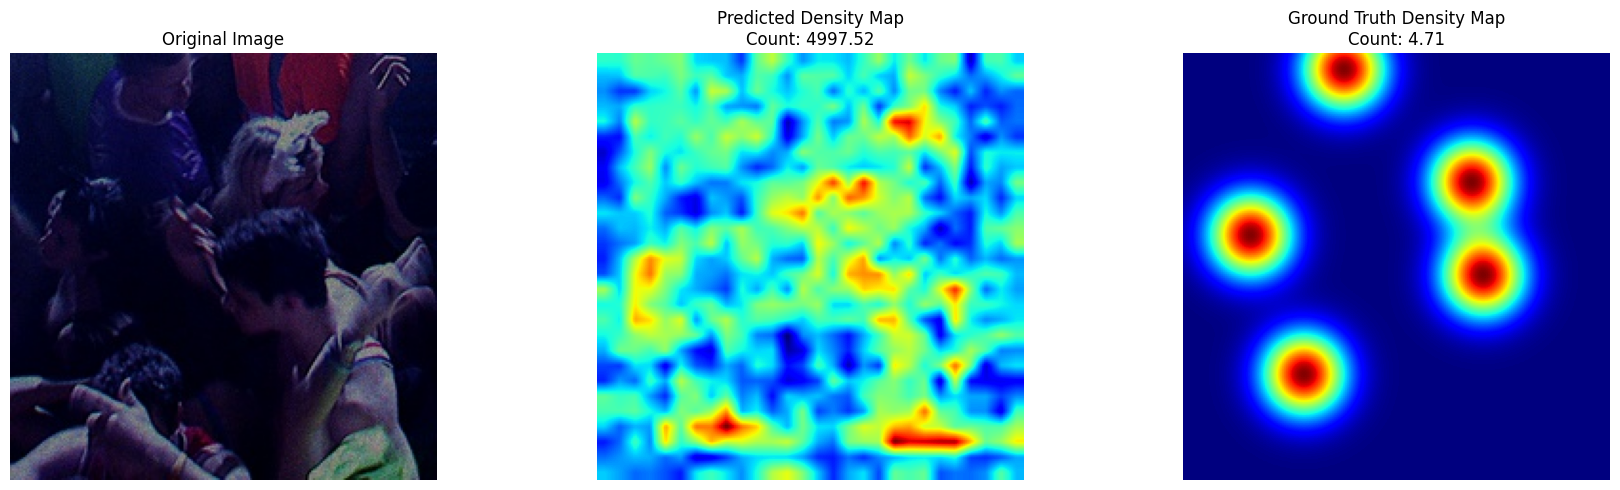

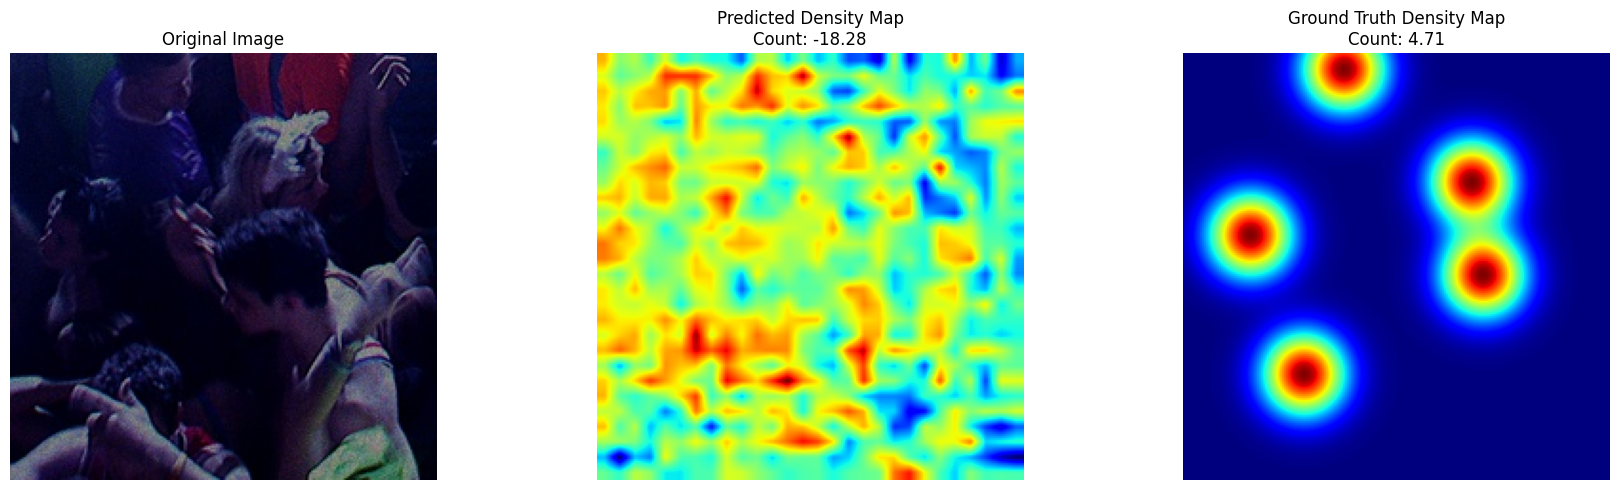

In [18]:
visualize_output(model, dataset=train_loader.dataset, index=5, device="cpu")
visualize_output(trained_model, dataset=train_loader.dataset, index=5, device="cpu")

In [13]:
model_name = 'b4-lr6-e10.pth'
model_folder = 'models/'

In [ ]:
# Save model
torch.save(trained_model.state_dict(), model_folder + model_name)

In [15]:
# Load saved model
trained_model = CSRNet()  # or your model class
trained_model.load_state_dict(torch.load(model_folder + model_name, map_location=torch.device('cpu')))
trained_model.eval()

C:\Users\ryan_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ryan_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [18]:
gt_density = np.load("Train_density_2/img_0001_crop_0_density.npy")  # Load a sample density map
gt_density_fixed = gt_density.sum() 
print(f"GT Density Map Count: {gt_density_fixed:.2f}")  

GT Density Map Count: 9.92
